In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Load dataset
df = pd.read_csv("/kaggle/input/datas/Crop_recommendation.csv")  # replace with actual filename

In [ ]:
# Separate features and labels
X_num = df[["temperature", "humidity", "ph", "water availability"]]

# Encode season
season_enc = OneHotEncoder(sparse=False)
X_season = season_enc.fit_transform(df[["season"]])

# Combine numeric + season
import numpy as np
X = np.hstack([X_num.values, X_season])

# Encode labels
label_enc = LabelEncoder()
y = label_enc.fit_transform(df["label"])

# One-hot target
y = tf.keras.utils.to_categorical(y)

# Normalize numeric features
scaler = StandardScaler()
X[:, :4] = scaler.fit_transform(X[:, :4])

In [ ]:
X

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(X.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(y.shape[1], activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

# Example prediction
sample = np.array([[28, 80, 6.5, 300]])  # numeric values
sample_season = season_enc.transform([["rainy"]])
sample_input = np.hstack([sample, sample_season])
sample_input[:, :4] = scaler.transform(sample_input[:, :4])

pred = model.predict(sample_input)
print("Predicted Crop:", label_enc.inverse_transform([np.argmax(pred)]))

In [ ]:
price = pd.read_csv("/kaggle/input/data-gov-in/9ef84268-d588-465a-a308-a864a43d0070.csv")
price

In [ ]:
df_filtered = price[price["State"].str.lower() == "Odisha"]

In [ ]:
df_filtered

In [ ]:
price

In [ ]:
df["season"].unique()

In [ ]:
import requests
import pandas as pd

# Example: Raipur, Chhattisgarh
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 21.25,
    "longitude": 81.63,
    "hourly": "temperature_2m,relative_humidity_2m",
    "timezone": "auto"
}

resp = requests.get(url, params=params).json()

# Convert to DataFrame
hourly = pd.DataFrame({
    "date": pd.to_datetime(resp["hourly"]["time"]),
    "temperature_2m": resp["hourly"]["temperature_2m"],
    "humidity_2m": resp["hourly"]["relative_humidity_2m"]
})

# Derive season from month
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "summer"
    elif month in [6, 7, 8, 9]:
        return "rainy"
    else:
        return "spring"

hourly["season"] = hourly["date"].dt.month.map(get_season)

print(hourly.head())

In [ ]:
import requests
import pandas as pd

# Raipur, Chhattisgarh
lat, lon = 21.25, 81.63

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": lat,
    "longitude": lon,
    "current": "temperature_2m,relative_humidity_2m,apparent_temperature,is_day,precipitation,"
               "rain,showers,snowfall,weather_code,cloudcover,pressure_msl,surface_pressure,"
               "windspeed_10m,winddirection_10m,windgusts_10m",
    "timezone": "auto",
    "daily":"rain_sum"
}

resp = requests.get(url, params=params).json()

# Current weather dict
current_weather = resp["current"]

# Convert to DataFrame (1-row table)
df = pd.DataFrame([current_weather])
print(df.T)  # transpose for easier view

In [ ]:
import requests

def get_soil_ph(lat, lon, stat="mean"):
    """
    Query SoilGrids REST API for soil pH in water (phh2o) at a location.
    Returns dict: { "0-5cm": 8.2, "5-15cm": 8.1, ... }
    """
    url = "https://rest.isric.org/soilgrids/v2.0/properties/query"
    params = {"lat": lat, "lon": lon, "property": "phh2o"}
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()

    out = {}
    try:
        layers = data["properties"]["layers"]
        ph_layer = next(layer for layer in layers if layer["name"] == "phh2o")
        for d in ph_layer["depths"]:
            label = d["label"]  # e.g. "0-5cm"
            val = d["values"].get(stat)
            if val is not None:
                out[label] = val / 10.0  # convert to real pH
    except Exception as e:
        print("Parse error:", e)
    return out


if __name__ == "__main__":
    lat, lon = 21.25, 81.63
    ph_profile = get_soil_ph(lat, lon)
    if ph_profile:
        print("Soil pH profile:")
        for depth, ph in ph_profile.items():
            print(f"  {depth}: {ph:.2f}")
    else:
        print("No pH data found.")

In [ ]:
import requests
from datetime import date, timedelta

def get_total_rainfall(latitude, longitude):
    # Last 30 days
    end_date = date.today()
    start_date = end_date - timedelta(days=30)

    url = (
        f"https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={latitude}&longitude={longitude}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=precipitation_sum&timezone=auto"
    )

    response = requests.get(url)
    data = response.json()

    # Extract rainfall values, ignoring None
    rainfall_values = [
        v for v in data.get("daily", {}).get("precipitation_sum", []) if v is not None
    ]
    total_rainfall = sum(rainfall_values)

    return {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": str(start_date),
        "end_date": str(end_date),
        "daily_rainfall": rainfall_values,
        "total_rainfall_mm": total_rainfall,
        "api_url": url,
    }

# Example: Chandigarh, India (30.7333, 76.7794)
rainfall_report = get_total_rainfall(30.7333, 76.7794)
rainfall_report

In [ ]:
import requests
import pandas as pd
from datetime import date, timedelta

# ---------- 1. Weather Data ----------
def get_weather_summary(lat, lon):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m,relative_humidity_2m",
        "timezone": "auto"
    }
    resp = requests.get(url, params=params).json()

    df = pd.DataFrame({
        "date": pd.to_datetime(resp["hourly"]["time"]),
        "temperature_2m": resp["hourly"]["temperature_2m"],
        "humidity_2m": resp["hourly"]["relative_humidity_2m"]
    })

    avg_temp = df["temperature_2m"].mean()
    avg_hum = df["humidity_2m"].mean()

    # Season from current date
    month = date.today().month
    if month in [12, 1, 2]:
        season = "winter"
    elif month in [3, 4, 5]:
        season = "summer"
    elif month in [6, 7, 8, 9]:
        season = "rainy"
    else:
        season = "spring"

    return avg_temp, avg_hum, season


# ---------- 2. Soil pH (first depth only) ----------
def get_soil_ph_first(lat, lon, stat="mean"):
    url = "https://rest.isric.org/soilgrids/v2.0/properties/query"
    params = {"lat": lat, "lon": lon, "property": "phh2o"}
    resp = requests.get(url, params=params).json()

    try:
        layers = resp["properties"]["layers"]
        ph_layer = next(layer for layer in layers if layer["name"] == "phh2o")
        first_depth = ph_layer["depths"][0]  # first depth
        val = first_depth["values"].get(stat)
        if val is not None:
            return val / 10.0
    except Exception:
        pass

    return None


# ---------- 3. Rainfall ----------
def get_total_rainfall(lat, lon):
    end_date = date.today()
    start_date = end_date - timedelta(days=30)
    url = (
        f"https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={lat}&longitude={lon}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=precipitation_sum&timezone=auto"
    )
    resp = requests.get(url).json()
    rainfall_values = [v for v in resp.get("daily", {}).get("precipitation_sum", []) if v is not None]
    return sum(rainfall_values)


# ---------- 4. Combine into one row ----------
def build_single_row(lat, lon, label="sample"):
    avg_temp, avg_hum, season = get_weather_summary(lat, lon)
    soil_ph = get_soil_ph_first(lat, lon)
    rainfall = get_total_rainfall(lat, lon)

    df = pd.DataFrame([{
        "temperature": avg_temp,
        "humidity": avg_hum,
        "ph": soil_ph,
        "water availability": rainfall,
        "season": season,
    }])
    return df


# Example: Raipur, Chhattisgarh
lat, lon =  26.0909,  81.7131
dataset = build_single_row(lat, lon, label="raipur_sample")

print(dataset)

In [ ]:
dataset = dataset.reset_index(drop=True)

In [ ]:
def preprocess_input(df):
    # numeric features
    df["water availability"] = 40
    X_num = df[["temperature", "humidity", "ph", "water availability"]].values
    
    # season one-hot (use transform, not fit_transform!)
    X_season = season_enc.transform(df[["season"]])
    
    # combine
    X = np.hstack([X_num, X_season])
    
    # scale numeric features
    X[:, :4] = scaler.transform(X[:, :4])
    
    return X

# Now preprocess dataset
X1 = preprocess_input(dataset)

# Predict
pred = model.predict(X1)
pred_labels = label_enc.inverse_transform(np.argmax(pred, axis=1))

print(pred_labels)

In [1]:
df["label"].value_counts()

NameError: name 'df' is not defined

In [ ]:
df.loc[df["label"] == "mungbean", ["temperature", "humidity", "ph", "water availability", "season"]].head()
#    temperature   humidity   ph  water availability season
# 0     27.02381  89.863095  7.3               151.2  rainymodel.save("crop_model.h5")

In [60]:
model.save("crop_model.h5")
import pickle
with open("label_enc.pkl", "wb") as f:
    pickle.dump(label_enc, f)

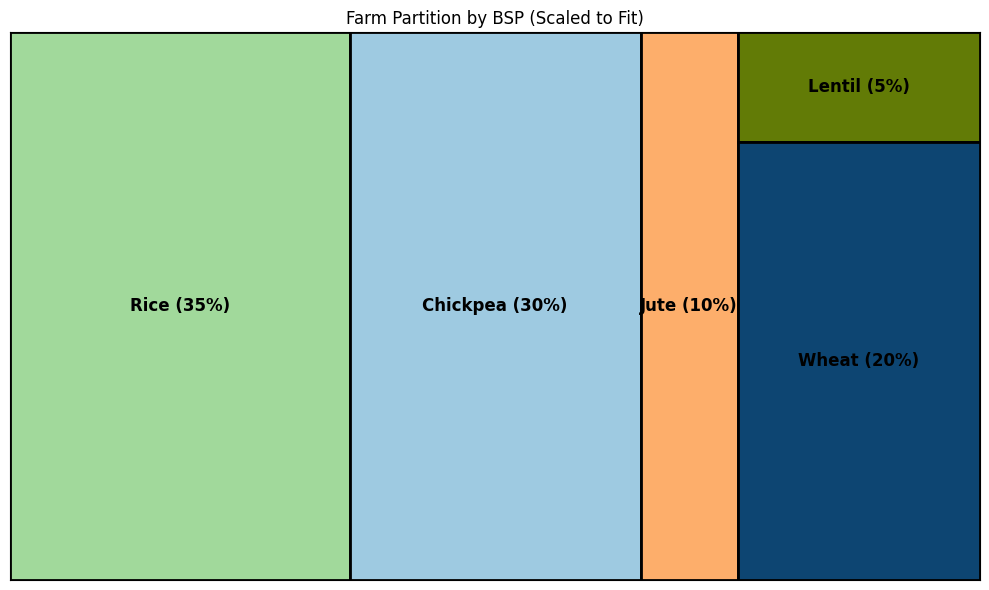

In [9]:
import matplotlib.pyplot as plt
from matplotlib import patches

# Real farm dimensions (can be very large, e.g. in meters)
farm_width = 620105   # input width
farm_height = 202154  # input height

# Crop labels and percentages
labels = ["Rice (35%)", "Chickpea (30%)", "Jute (10%)","Lentil (5%)","Wheat (20%)"]
fractions = [0.35, 0.30, 0.10, 0.05, 0.20]

def bsp_sequential_partition(x, y, w, h, fracs):
    rects = []
    remaining_rect = (x, y, w, h)
    remaining_frac = sum(fracs)
    for f in fracs[:-1]:
        target_fraction = f / remaining_frac
        rx, ry, rw, rh = remaining_rect
        if rw >= rh:
            cut_w = rw * target_fraction
            rect_i = (rx, ry, cut_w, rh)
            remaining_rect = (rx + cut_w, ry, rw - cut_w, rh)
        else:
            cut_h = rh * target_fraction
            rect_i = (rx, ry, rw, cut_h)
            remaining_rect = (rx, ry + cut_h, rw, rh - cut_h)
        rects.append(rect_i)
        remaining_frac -= f
    rects.append(remaining_rect)
    return rects

# --- SAFE SCALING ---
canvas_max_width = 1000   # fix width of the image
scale = canvas_max_width / farm_width
canvas_width = canvas_max_width
canvas_height = int(farm_height * scale)

# Partition using *scaled* dimensions
rectangles = bsp_sequential_partition(0, 0, canvas_width, canvas_height, fractions)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, canvas_width)
ax.set_ylim(0, canvas_height)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Farm Partition by BSP (Scaled to Fit)")

colors = ["#a1d99b", "#9ecae1", "#fdae6b", "#627b06", "#0d4572"]

for idx, (rx, ry, rw, rh) in enumerate(rectangles):
    rect_patch = patches.Rectangle((rx, ry), rw, rh,
                                   facecolor=colors[idx], edgecolor="black", linewidth=2)
    ax.add_patch(rect_patch)
    cx, cy = rx + rw / 2, ry + rh / 2
    ax.text(cx, cy, labels[idx], ha='center', va='center', fontsize=12, weight='bold')

plt.gca().invert_yaxis()  # match image-like orientation
plt.tight_layout()
plt.show()


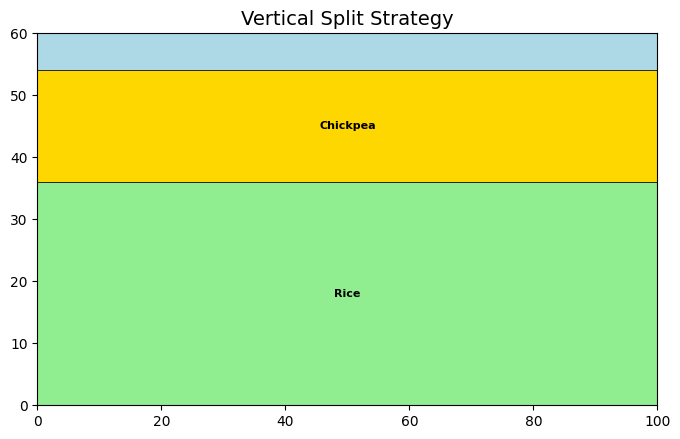

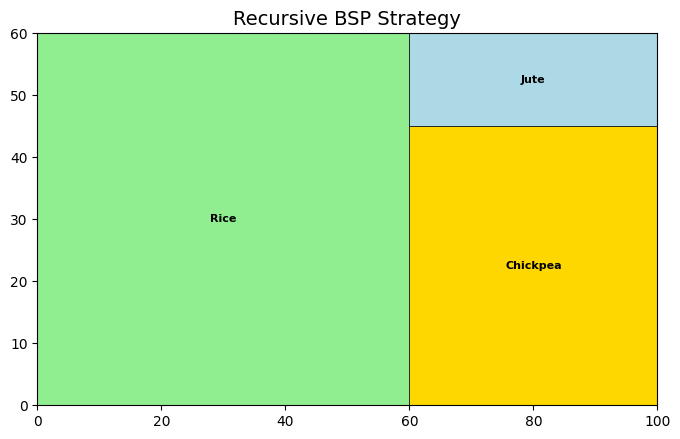

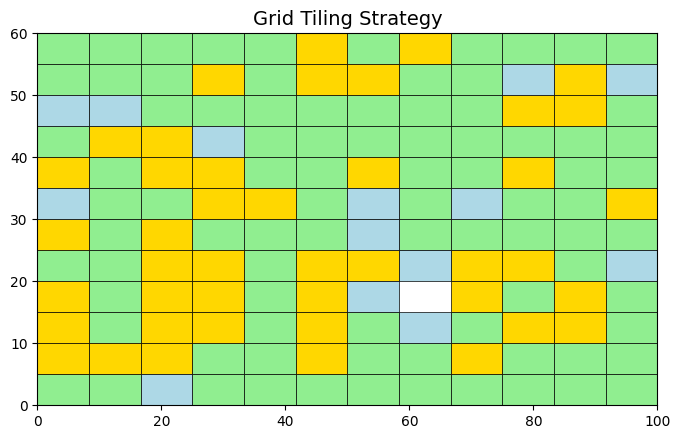

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# --------------------
# Strategies
# --------------------
def vertical_split(farm_w, farm_h, crop_probs):
    """Simple vertical partition."""
    total_area = farm_w * farm_h
    start_y = 0
    allocations = []
    for crop, prob in crop_probs.items():
        h = farm_h * prob
        allocations.append(((0, start_y, farm_w, h), crop))
        start_y += h
    return allocations

def recursive_bsp(farm_w, farm_h, crop_probs, depth=0):
    """Recursive BSP splitting strategy."""
    crops = list(crop_probs.items())
    random.shuffle(crops)
    allocations = []

    def split(x, y, w, h, crops_left):
        if not crops_left:
            return
        if len(crops_left) == 1:
            crop, _ = crops_left[0]
            allocations.append(((x, y, w, h), crop))
            return
        # split by probability of first crop
        crop, prob = crops_left[0]
        total_prob = sum(p for _, p in crops_left)
        ratio = prob / total_prob

        if w > h:  # vertical cut
            split_w = w * ratio
            allocations.append(((x, y, split_w, h), crop))
            split(x + split_w, y, w - split_w, h, crops_left[1:])
        else:      # horizontal cut
            split_h = h * ratio
            allocations.append(((x, y, w, split_h), crop))
            split(x, y + split_h, w, h - split_h, crops_left[1:])

    split(0, 0, farm_w, farm_h, crops)
    return allocations

def grid_tiling(farm_w, farm_h, crop_probs, grid_size=10):
    """Grid tiling strategy with proportional allocation."""
    crops = list(crop_probs.items())
    allocations = []
    total_cells = grid_size * grid_size
    crop_cells = {crop: int(prob * total_cells) for crop, prob in crops}

    grid = [(i, j) for i in range(grid_size) for j in range(grid_size)]
    random.shuffle(grid)

    idx = 0
    for crop, count in crop_cells.items():
        for _ in range(count):
            if idx >= len(grid):
                break
            gx, gy = grid[idx]
            cell_w = farm_w / grid_size
            cell_h = farm_h / grid_size
            allocations.append(((gx*cell_w, gy*cell_h, cell_w, cell_h), crop))
            idx += 1
    return allocations

# --------------------
# Visualization
# --------------------
def plot_farm(farm_w, farm_h, allocations, title="Farm Partition"):
    colors = {
        "Rice": "lightgreen",
        "Chickpea": "gold",
        "Jute": "lightblue",
        "Wheat": "sandybrown"
    }

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, farm_w)
    ax.set_ylim(0, farm_h)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)

    for (x, y, w, h), crop in allocations:
        rect = patches.Rectangle((x, y), w, h,
                                 linewidth=0.5, edgecolor='black',
                                 facecolor=colors.get(crop, "gray"))
        ax.add_patch(rect)
        if w > 10 and h > 10:  # avoid cluttering
            ax.text(x + w/2, y + h/2, crop,
                    ha='center', va='center', fontsize=8, weight='bold')

    plt.show()

# --------------------
# Example Run
# --------------------
farm_w, farm_h = 100, 60
crop_probs = {"Rice": 0.6, "Chickpea": 0.3, "Jute": 0.1}

# Try different strategies
alloc_v = vertical_split(farm_w, farm_h, crop_probs)
alloc_bsp = recursive_bsp(farm_w, farm_h, crop_probs)
alloc_grid = grid_tiling(farm_w, farm_h, crop_probs, grid_size=12)

plot_farm(farm_w, farm_h, alloc_v, "Vertical Split Strategy")
plot_farm(farm_w, farm_h, alloc_bsp, "Recursive BSP Strategy")
plot_farm(farm_w, farm_h, alloc_grid, "Grid Tiling Strategy")


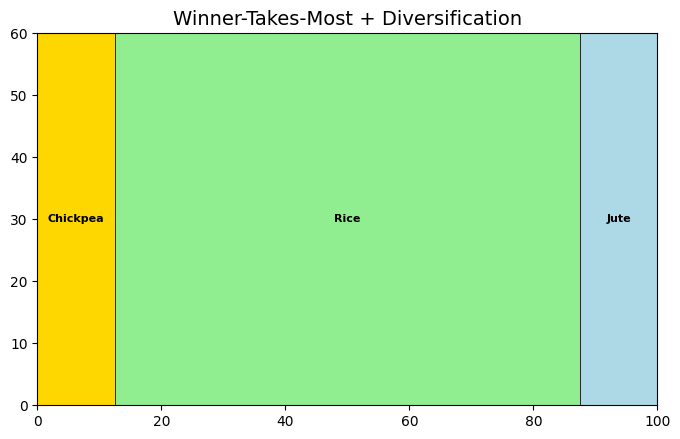

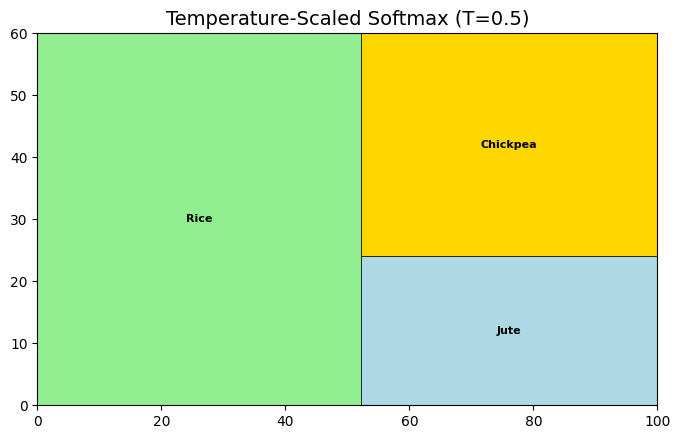

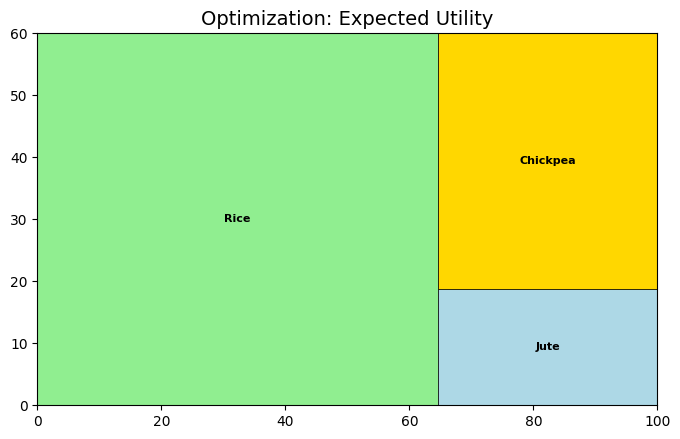

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

# --------------------
# Allocation Strategies
# --------------------

def winner_takes_most(probs, top_share=0.75):
    """Top crop takes majority, rest split evenly."""
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    top_crop, _ = sorted_probs[0]
    n_rest = len(sorted_probs) - 1

    alloc = {c: 0 for c, _ in probs.items()}
    alloc[top_crop] = top_share
    if n_rest > 0:
        rest_share = 1 - top_share
        for crop, _ in sorted_probs[1:]:
            alloc[crop] = rest_share / n_rest
    return alloc

def temperature_scaled(probs, T=0.7):
    """Softmax with temperature scaling."""
    crops, vals = zip(*probs.items())
    logits = np.array(vals)
    scaled = np.exp(logits / T) / np.sum(np.exp(logits / T))
    return dict(zip(crops, scaled))

def optimization_expected_utility(probs, yields=None):
    """
    Simple allocation by maximizing expected utility = prob * yield.
    Yields can be a dict; if None, assume yield ~1 with small random variation.
    """
    if yields is None:
        yields = {c: 1 + random.uniform(-0.2, 0.2) for c in probs.keys()}

    utilities = {c: probs[c] * yields[c] for c in probs.keys()}
    total = sum(utilities.values())
    alloc = {c: utilities[c] / total for c in utilities}
    return alloc

# --------------------
# Recursive BSP Splitter
# --------------------
def recursive_bsp(farm_w, farm_h, crop_alloc, depth=0):
    """Recursive BSP partition based on allocation dictionary."""
    crops = list(crop_alloc.items())
    random.shuffle(crops)
    allocations = []

    def split(x, y, w, h, crops_left):
        if not crops_left:
            return
        if len(crops_left) == 1:
            crop, _ = crops_left[0]
            allocations.append(((x, y, w, h), crop))
            return
        crop, share = crops_left[0]
        total_share = sum(p for _, p in crops_left)
        ratio = share / total_share

        if w > h:  # vertical cut
            split_w = w * ratio
            allocations.append(((x, y, split_w, h), crop))
            split(x + split_w, y, w - split_w, h, crops_left[1:])
        else:      # horizontal cut
            split_h = h * ratio
            allocations.append(((x, y, w, split_h), crop))
            split(x, y + split_h, w, h - split_h, crops_left[1:])

    split(0, 0, farm_w, farm_h, crops)
    return allocations

# --------------------
# Visualization
# --------------------
def plot_farm(farm_w, farm_h, allocations, title="Farm Partition"):
    colors = {
        "Rice": "lightgreen",
        "Chickpea": "gold",
        "Jute": "lightblue",
        "Wheat": "sandybrown",
        "Maize": "pink"
    }

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, farm_w)
    ax.set_ylim(0, farm_h)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)

    for (x, y, w, h), crop in allocations:
        rect = patches.Rectangle((x, y), w, h,
                                 linewidth=0.5, edgecolor='black',
                                 facecolor=colors.get(crop, "gray"))
        ax.add_patch(rect)
        if w > 8 and h > 8:
            ax.text(x + w/2, y + h/2, crop,
                    ha='center', va='center', fontsize=8, weight='bold')

    plt.show()

# --------------------
# Example Usage
# --------------------
farm_w, farm_h = 100, 60
crop_probs = {"Rice": 0.6, "Chickpea": 0.3, "Jute": 0.1}

# Strategy A: Winner-Takes-Most
alloc_A = winner_takes_most(crop_probs, top_share=0.75)
bsp_A = recursive_bsp(farm_w, farm_h, alloc_A)
plot_farm(farm_w, farm_h, bsp_A, "Winner-Takes-Most + Diversification")

# Strategy B: Temperature-Scaled Softmax
alloc_B = temperature_scaled(crop_probs, T=0.5)
bsp_B = recursive_bsp(farm_w, farm_h, alloc_B)
plot_farm(farm_w, farm_h, bsp_B, "Temperature-Scaled Softmax (T=0.5)")

# Strategy C: Optimization (Expected Utility)
alloc_C = optimization_expected_utility(crop_probs)
bsp_C = recursive_bsp(farm_w, farm_h, alloc_C)
plot_farm(farm_w, farm_h, bsp_C, "Optimization: Expected Utility")
